In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf


import warnings

warnings.filterwarnings("ignore")

In [41]:
# Load and plot closing prices
def plot_closing_prices(tickers, file):
    plt.figure(figsize=(14, 7))
    # for ticker in tickers:
    #     data = pd.read_csv(f'{ticker}.txt', delimiter=',')  # Change delimiter as necessary (e.g., ',' for commas)  
    #     print(len(data))
    plt.plot(tickers['Date'], tickers['Close'])
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    label = 'Stock Closing Prices for ' + file
    plt.title(label)
    plt.legend()
    plt.show()
    


In [42]:

def load_data(ticker, lookback):
    # Load the text file; adjust delimiter as needed
    data = pd.read_csv(f'{ticker}.txt', delimiter=',')  # Change delimiter as necessary (e.g., ',' for commas)
    print(f'Stock Data for {ticker}')
    data.head()
    plot_closing_prices(data, ticker)
    closing_prices = data['Close'].values  # Adjust column name if needed
    input_sequences = []
    labels = []
    
    for i in range(len(closing_prices) - lookback - 2):  # -2 for predicting 2 days ahead
        input_sequences.append(closing_prices[i:i + lookback])
        labels.append(closing_prices[i + lookback + 2])  # 2 days ahead
    
    return np.array(input_sequences), np.array(labels)

Stock Data for aame.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


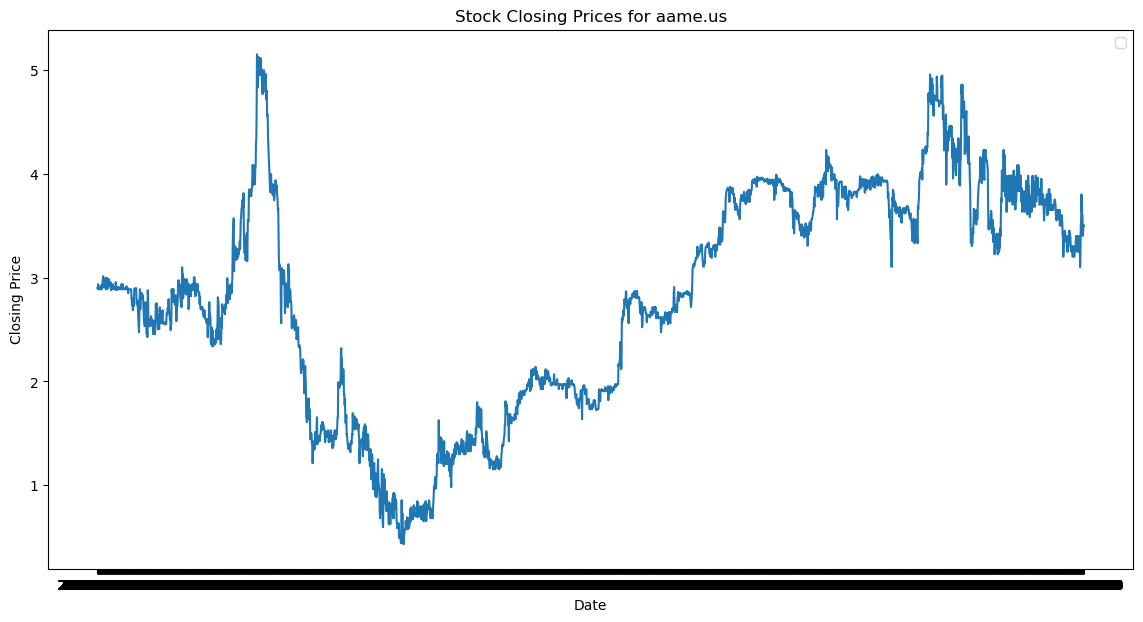

Stock Data for aapl.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


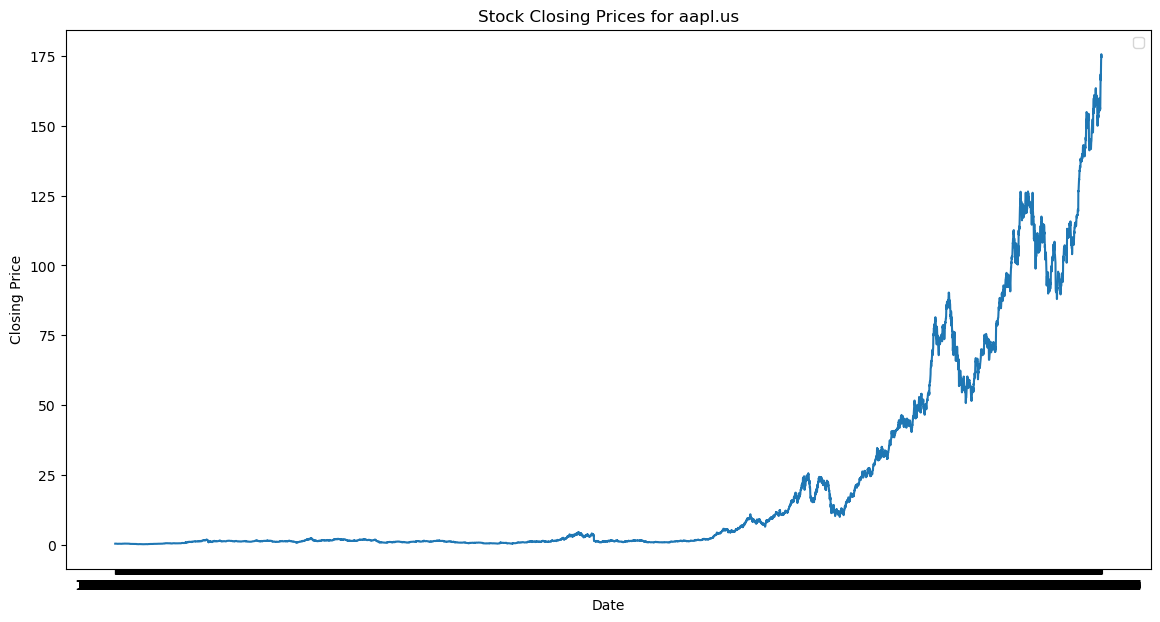

Stock Data for ab.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


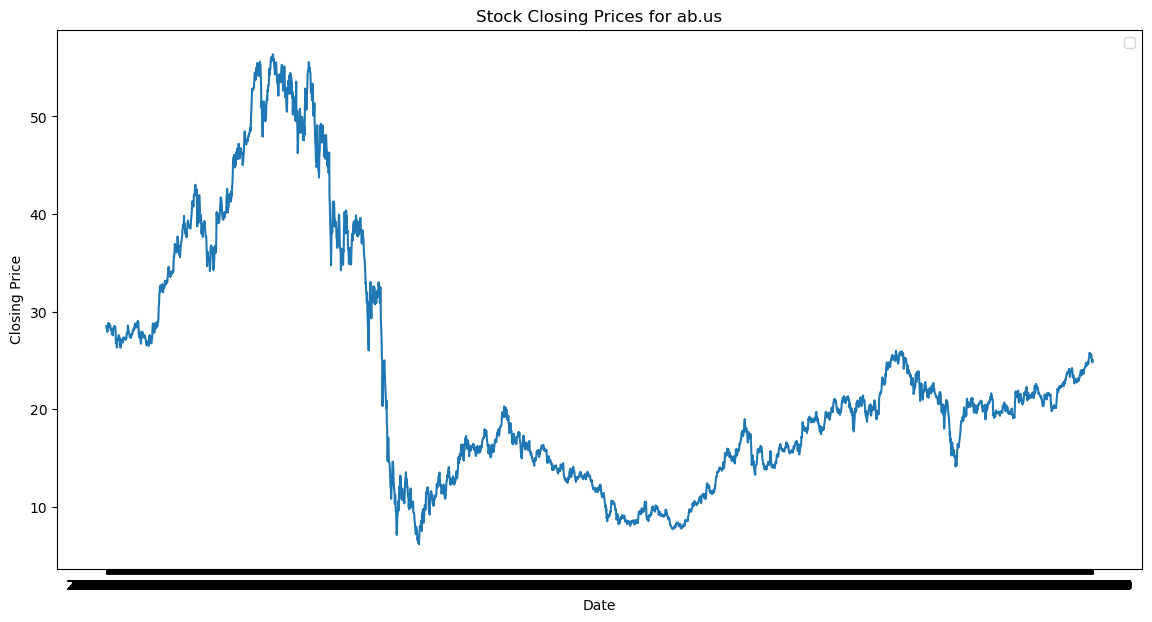

Stock Data for abus.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


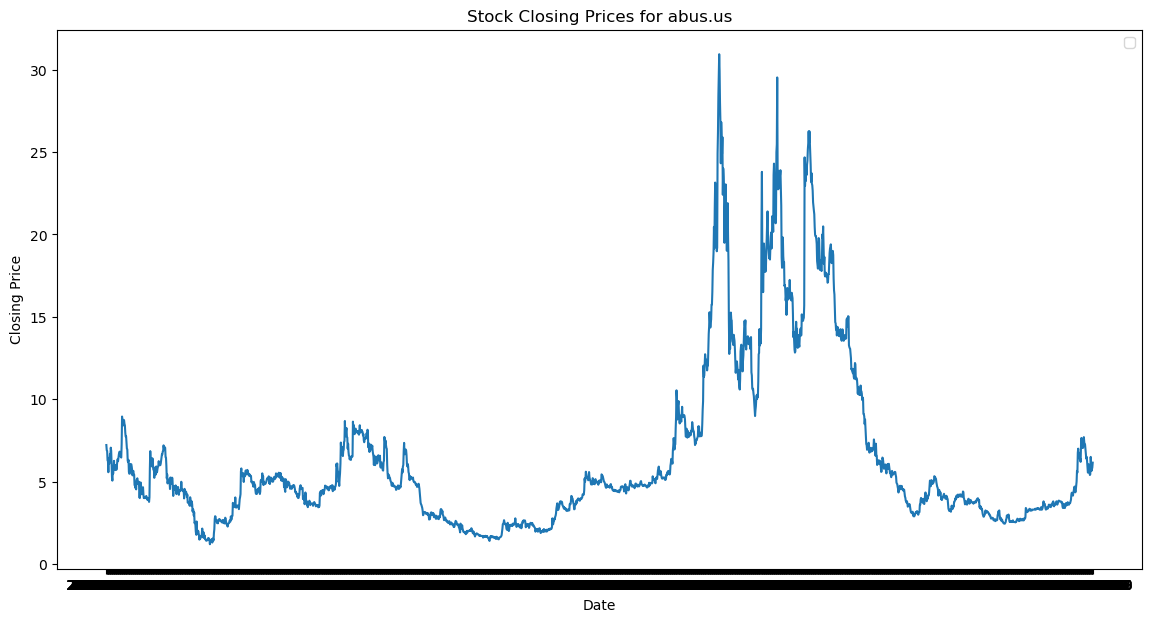

In [43]:



# Example: Load data with a lookback of 5 days
lookback = 5
inputs, labels = [], []
for ticker in ['aame.us', 'aapl.us', 'ab.us', 'abus.us']:
    input_seq, label_seq = load_data(ticker, lookback)
    inputs.append(input_seq)
    labels.append(label_seq)

# Concatenate arrays
X = np.concatenate(inputs)
y = np.concatenate(labels)

In [44]:
print(X.shape)
X

(16912, 5)


array([[2.8973, 2.8973, 2.9357, 2.8873, 2.8873],
       [2.8973, 2.9357, 2.8873, 2.8873, 2.9066],
       [2.9357, 2.8873, 2.8873, 2.9066, 2.8973],
       ...,
       [6.    , 5.65  , 5.4   , 5.45  , 6.5   ],
       [5.65  , 5.4   , 5.45  , 6.5   , 6.1   ],
       [5.4   , 5.45  , 6.5   , 6.1   , 5.65  ]])

In [45]:

X= pd.DataFrame(X, columns=['Open','High','Low','Close','Volume'])
X.head()

,Open,High,Low,Close,Volume
0,2.8973,2.8973,2.9357,2.8873,2.8873
1,2.8973,2.9357,2.8873,2.8873,2.9066
2,2.9357,2.8873,2.8873,2.9066,2.8973
3,2.8873,2.8873,2.9066,2.8973,2.8873
4,2.8873,2.9066,2.8973,2.8873,2.8973



## Scaling The Data

In [46]:

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for model input: (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_scaled

array([[[0.01585492],
        [0.01585492],
        [0.01575997],
        [0.01532179],
        [0.01527334]],

       [[0.01585492],
        [0.01608322],
        [0.015478  ],
        [0.01532179],
        [0.01538429]],

       [[0.01608322],
        [0.01579547],
        [0.015478  ],
        [0.01543309],
        [0.01533083]],

       ...,

       [[0.03430147],
        [0.03222061],
        [0.03011655],
        [0.03010095],
        [0.03604201]],

       [[0.03222061],
        [0.03073428],
        [0.03040784],
        [0.03615633],
        [0.0337425 ]],

       [[0.03073428],
        [0.03103154],
        [0.03652496],
        [0.03384952],
        [0.03115554]]])

In [ ]:
#Model Creation


def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50),
        tf.keras.layers.Dense(1)  # Predicting one value (the closing price)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model((X_scaled.shape[1], 1))

In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 4, 50)               │           5,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,043 (43.14 KB)

 Trainable params: 11,043 (43.14 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model


In [50]:
# Model Training
history = model.fit(X_scaled, y, epochs=50, batch_size=32)

Epoch 1/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 813.0153
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 402.7841
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 231.2137
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 154.7713
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 98.2483
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 63.0707
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 41.0067
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 23.2269
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 19.2722
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 14.1207
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 9.8072
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 6.6652
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.2687
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.2681
Epoch 15/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 

In [75]:
# Plot training loss
def plot_model_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

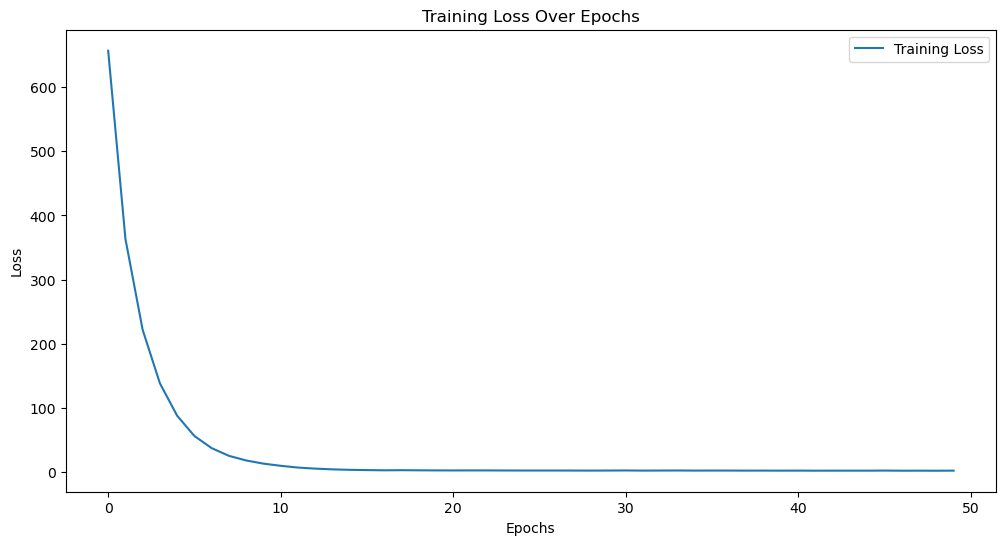

In [76]:
plot_model_loss(history)

In [52]:
final_training_loss = history.history['loss'][-1]
print(f'Final Training Loss: {final_training_loss:.4f}')

Final Training Loss: 1.9608


## Validating Set

Stock Data for ab.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


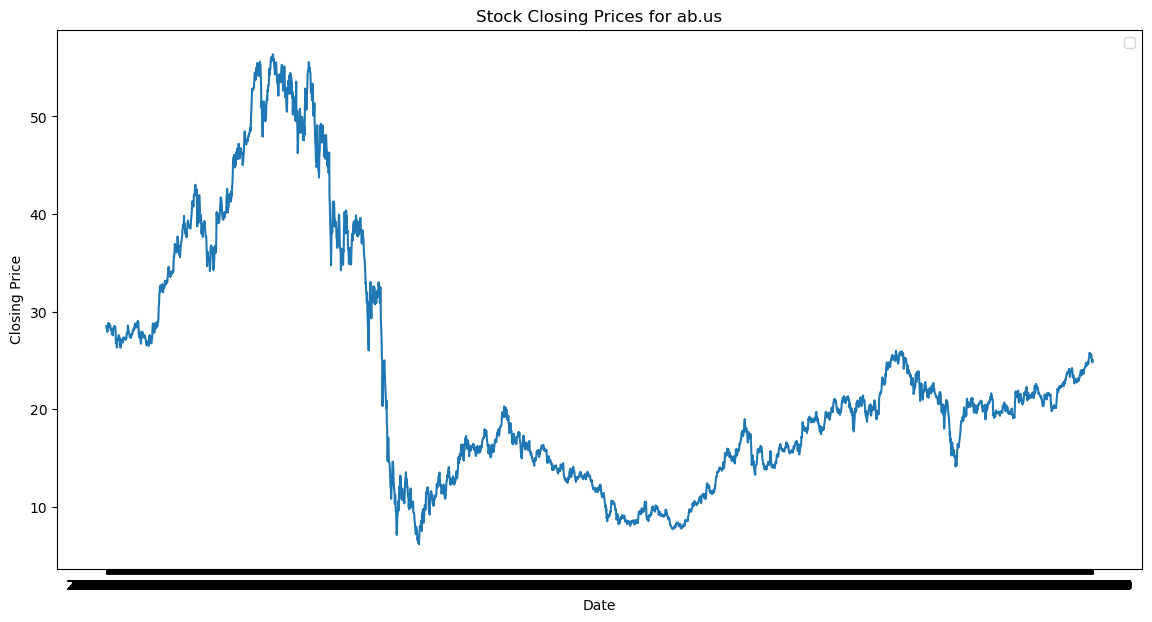

Stock Data for abus.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


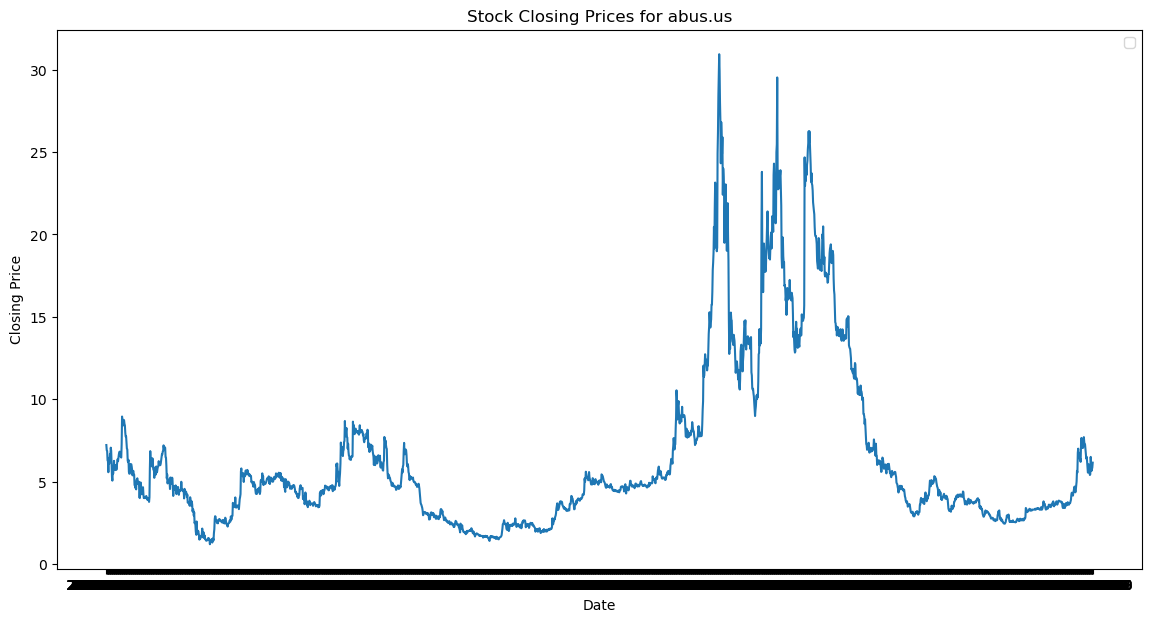

In [64]:
# Load validation data similarly
# For demonstration, using the same function
lookback = 5
val_inputs, val_labels = [], []
for ticker in ['ab.us', 'abus.us']:
    input_seq, label_seq = load_data(ticker, lookback)
    val_inputs.append(input_seq)
    val_labels.append(label_seq)

# Concatenate arrays
X_val = np.concatenate(val_inputs)
y_val = np.concatenate(val_labels)

In [67]:
print(X_val.shape)
X_val[:5]


(5636, 5)


array([[28.528, 28.264, 28.254, 27.928, 28.007],
       [28.264, 28.254, 27.928, 28.007, 28.534],
       [28.254, 27.928, 28.007, 28.534, 28.727],
       [27.928, 28.007, 28.534, 28.727, 28.848],
       [28.007, 28.534, 28.727, 28.848, 28.752]])

In [68]:
X_val= pd.DataFrame(X_val, columns=['Open','High','Low','Close','Volume'])
X_val.head()

,Open,High,Low,Close,Volume
0,28.528,28.264,28.254,27.928,28.007
1,28.264,28.254,27.928,28.007,28.534
2,28.254,27.928,28.007,28.534,28.727
3,27.928,28.007,28.534,28.727,28.848
4,28.007,28.534,28.727,28.848,28.752


In [69]:
X_val_scaled = scaler.transform(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

X_val_scaled

array([[[0.16823767],
        [0.1666681 ],
        [0.16325997],
        [0.15973225],
        [0.15968135]],

       [[0.1666681 ],
        [0.16660865],
        [0.16136075],
        [0.16018784],
        [0.16271097]],

       [[0.16660865],
        [0.16467048],
        [0.16182099],
        [0.16322707],
        [0.16382049]],

       ...,

       [[0.03430147],
        [0.03222061],
        [0.03011655],
        [0.03010095],
        [0.03604201]],

       [[0.03222061],
        [0.03073428],
        [0.03040784],
        [0.03615633],
        [0.0337425 ]],

       [[0.03073428],
        [0.03103154],
        [0.03652496],
        [0.03384952],
        [0.03115554]]])

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4321
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


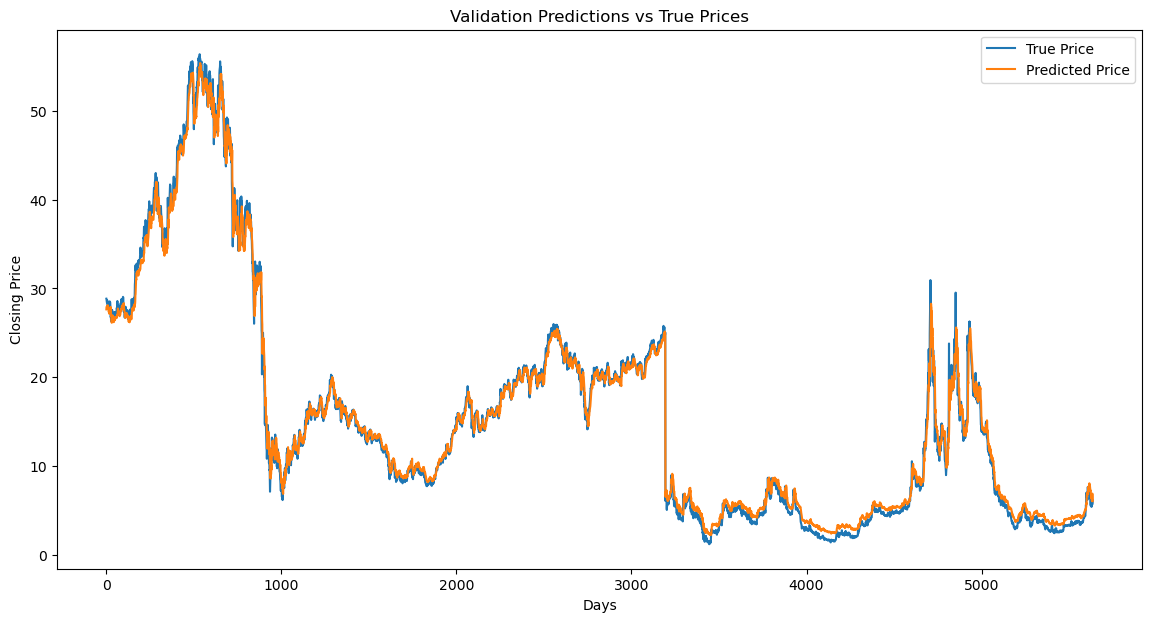

In [81]:
val_loss = model.evaluate(X_val_scaled, y_val)
predictions = model.predict(X_val_scaled)

    # Plot validation predictions
def pred_plot(predictions, actual):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='True Price')
    plt.plot(predictions, label='Predicted Price')
    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.title('Validation Predictions vs True Prices')
    plt.legend()
    plt.show()

pred_plot(predictions, y_val)

In [94]:
train_loss = model.evaluate(X_scaled, y)
print(f'First Model Train Loss: {train_loss:.4f}')

val_loss = model2.evaluate(X_val_scaled, y_val)
print(f'First Model Validation Loss: {val_loss:.4f}')

529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2394
First Model Train Loss: 1.8318
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6148
First Model Validation Loss: 1.2931


## Trying 3 different model

## Model 1

In [79]:

# Model 1: Simple Conv1D + Maxpooling1D + 2SimpleRNN
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=96, kernel_size=2, activation='relu', input_shape=(X_scaled.shape[1], 1)),  # Conv1D layer
    tf.keras.layers.MaxPooling1D(pool_size=2),  # MaxPooling1D to downsample the output of Conv1D
    tf.keras.layers.SimpleRNN(50, return_sequences=True),  # Simple RNN layer (with return_sequences=True)
    tf.keras.layers.Dropout(0.2),  # Dropout for regularization
    tf.keras.layers.SimpleRNN(50),  # Another RNN layer without return_sequences
    tf.keras.layers.Dense(1)  # Output layer for regression (predicting the next closing price)

])

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Summary of Model 1
model1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 4, 96)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 96)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ (None, 2, 50)               │           7,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,739 (49.76 KB)

 Trainable params: 12,739 (49.76 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Train Model 1
history1 = model1.fit(X_scaled, y, epochs=50, batch_size=32, verbose=1)



Epoch 1/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 795.6085
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 385.4776
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 227.3291
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 148.3193
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 96.8737
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 54.2137
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 39.5959
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 26.3825
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 20.9410
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 13.8154
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 10.1989
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7.6887
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.6811
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.6344
Epoch 15/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3

In [93]:
train_loss1 = model1.evaluate(X_scaled, y)
print(f'Model 1 Train Loss: {train_loss1:.4f}')

val_loss1 = model1.evaluate(X_val_scaled, y_val)
print(f'Model 1 Vlaidation Loss: {val_loss1:.4f}')

529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7349
Model 1 Train Loss: 1.7004
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3563
Model 1 Vlaidation Loss: 1.0998


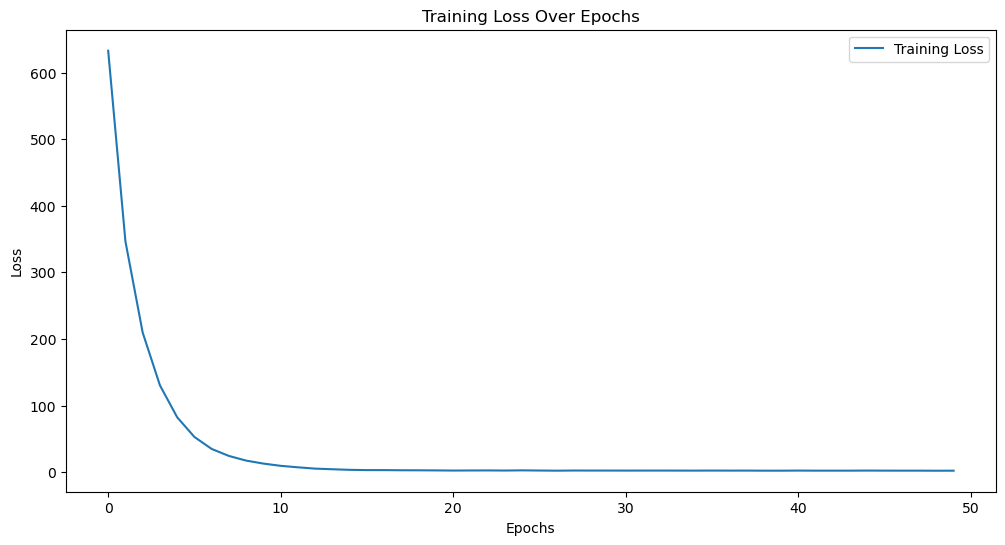

In [83]:
plot_model_loss(history1)

## Model 2

In [84]:
# Model 2: Conv1D + GRU + More Layers
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_scaled.shape[1], 1)),  # Conv1D layer
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    tf.keras.layers.GRU(100, return_sequences=True),  # GRU layer (with return_sequences=True for stacking)
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.GRU(100),  # Another GRU layer without return_sequences
    tf.keras.layers.Dense(1)  # Output layer for regression (predicting the next closing price)
])

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Summary of Model 2
model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 3, 128)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 1, 100)              │          69,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,493 (701.14 KB)

 Trainable params: 179,493 (701.14 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:

# Train Model 2
history2 = model2.fit(X_scaled, y, epochs=25, batch_size=32, verbose=1)


Epoch 1/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 638.1619
Epoch 2/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 178.1005
Epoch 3/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 72.6760
Epoch 4/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 33.0621
Epoch 5/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 22.1420
Epoch 6/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12.5257
Epoch 7/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.8591
Epoch 8/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.0232
Epoch 9/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.2417
Epoch 10/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.9778
Epoch 11/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.3704
Epoch 12/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5819
Epoch 13/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.3221
Epoch 14/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2545
Epoch 15/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/

In [90]:
train_loss2 = model2.evaluate(X_scaled, y)
print(f'Model 2 Train Loss: {train_loss2:.4f}')

val_loss2 = model2.evaluate(X_val_scaled, y_val)
print(f'Model 2 Vlaidation Loss: {val_loss2:.4f}')

529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6009
Model 2 Train Loss: 1.3654
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6148
Model 2 Vlaidation Loss: 1.2931


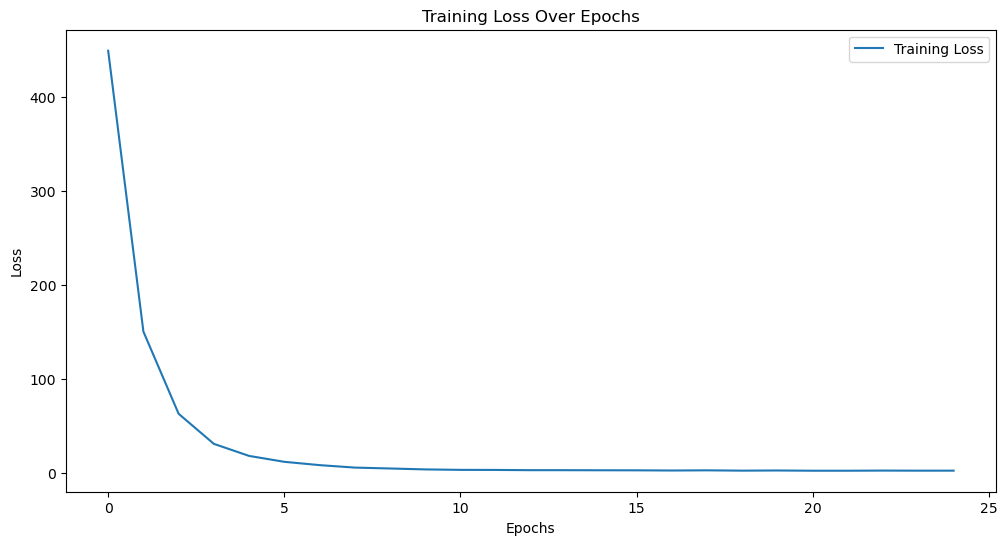

In [91]:
plot_model_loss(history2)

## Model 3

In [96]:
# Model 3: Deep Conv1D + GRU with More Units
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(X_scaled.shape[1], 1)),  # Conv1D layer
    tf.keras.layers.MaxPooling1D(pool_size=2),  # MaxPooling1D to downsample the output of Conv1D
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),  # Additional Conv1D layer
    tf.keras.layers.MaxPooling1D(pool_size=2),  # Another MaxPooling1D layer
    tf.keras.layers.GRU(200, return_sequences=True),  # GRU layer (with return_sequences=True)
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.GRU(200),  # Another GRU layer without return_sequences
    tf.keras.layers.Dense(1)  # Output layer for regression (predicting the next closing price)
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Summary of Model 3
model3.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 5, 256)              │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 2, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 1, 200)              │         274,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 200)                 │         241,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 714,089 (2.72 MB)

 Trainable params: 714,089 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Train Model 3
history3 = model3.fit(X_scaled, y, epochs=35, batch_size=32, verbose=1)



Epoch 1/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 530.1055
Epoch 2/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 53.3049
Epoch 3/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 18.3524
Epoch 4/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 8.9045
Epoch 5/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 5.3357
Epoch 6/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 3.4528
Epoch 7/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 3.2326
Epoch 8/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.2261
Epoch 9/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2.7807
Epoch 10/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 3.1312
Epoch 11/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2.6099
Epoch 12/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 2.5913
Epoch 13/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 2.7894
Epoch 14/35
529/529 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 2.4896
Epoch 15/35
529/529 ━━━━━━━━━━━━━━━━

In [ ]:
train_loss3 = model3.evaluate(X_scaled, y)
print(f'Model 3 Train Loss: {train_loss3:.4f}')

val_loss3 = model3.evaluate(X_val_scaled, y_val)
print(f'Model 3 Validation Loss: {val_loss3:.4f}')

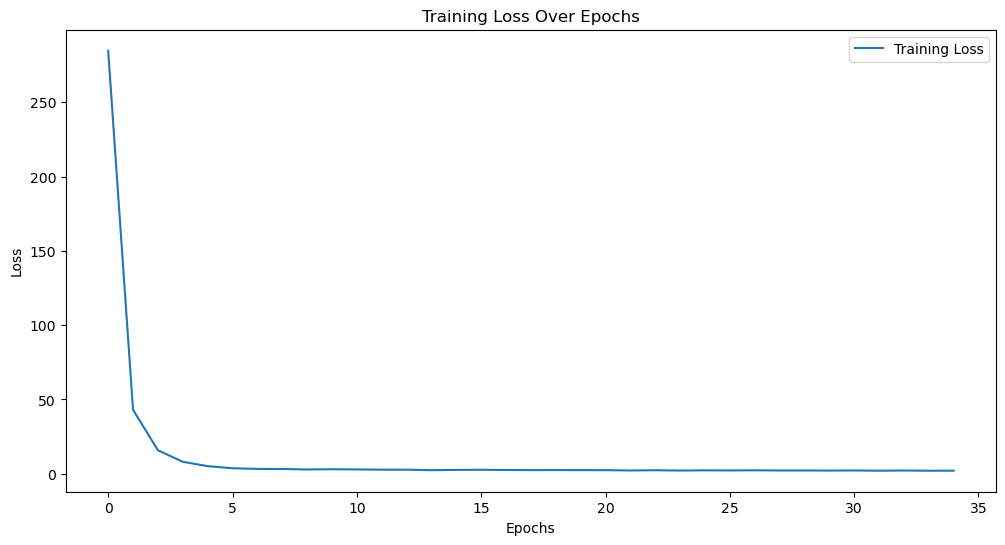

In [98]:
plot_model_loss(history3)

## Testing

Stock Data for aapl.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


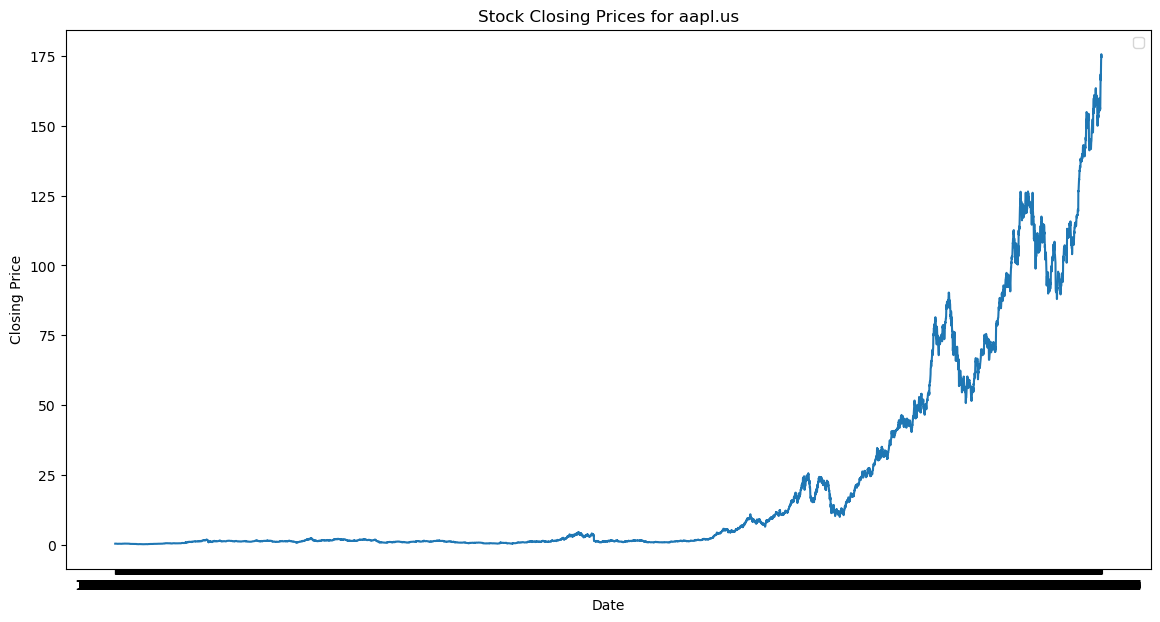

Stock Data for ab.us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


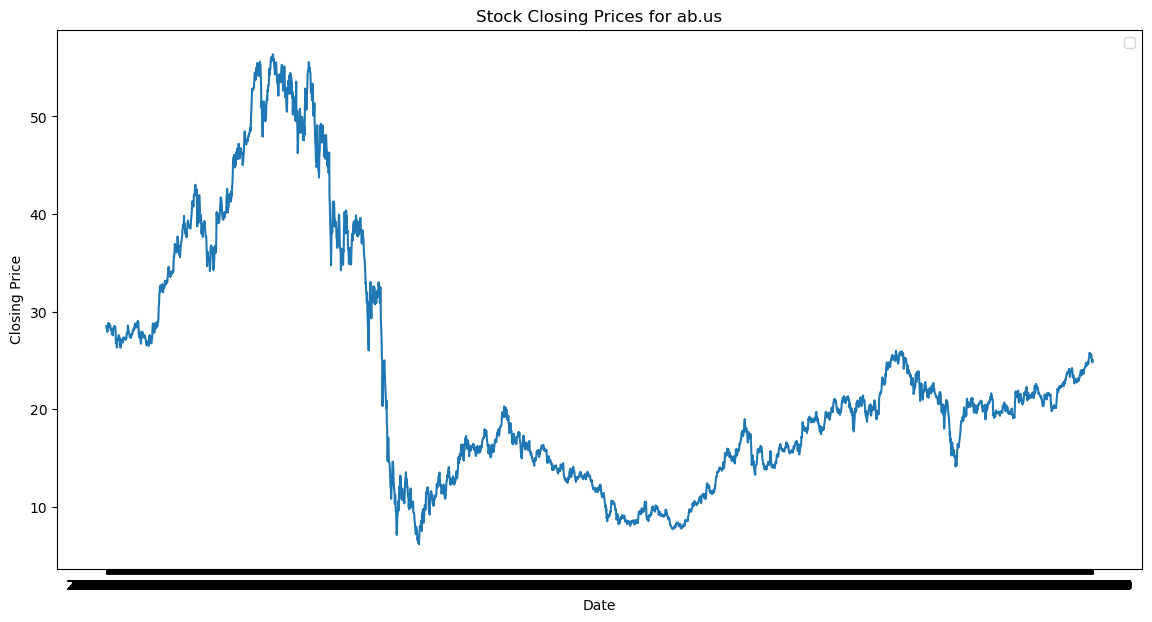

array([[[0.00114965],
        [0.00113455],
        [0.00115648],
        [0.00107076],
        [0.00120012]],

       [[0.00113455],
        [0.00118021],
        [0.00108168],
        [0.00120393],
        [0.00123685]],

       [[0.00118021],
        [0.00110387],
        [0.0012162 ],
        [0.00124078],
        [0.00130308]],

       ...,

       [[0.15076437],
        [0.14930777],
        [0.14659228],
        [0.14596058],
        [0.14613144]],

       [[0.14930777],
        [0.14959909],
        [0.14744868],
        [0.14659495],
        [0.14498168]],

       [[0.14959909],
        [0.15047305],
        [0.14808952],
        [0.14544155],
        [0.14239473]]])

In [71]:
# Load test data similarly
lookback = 5
test_inputs, test_labels = [], []
for ticker in ['aapl.us', 'ab.us']:
    input_seq, label_seq = load_data(ticker, lookback)
    test_inputs.append(input_seq)
    test_labels.append(label_seq)

# Concatenate arrays
X_test = np.concatenate(test_inputs)
y_test = np.concatenate(test_labels)

X_test_scaled = scaler.transform(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
X_test_scaled

## Best Model is Model 1
#### validation loss: Model 1 Validation Loss: 1.0998

In [105]:
print(f'First Model Train Loss: {train_loss}')
print(f'First Model Validation Loss: {val_loss}')
print('\n')
print(f'Model 1 Train Loss: {train_loss1}')
print(f'Model 1 Validation Loss: {val_loss1}')
print('\n')
print(f'Model 2 Train Loss: {train_loss2}')
print(f'Model 2 Validation Loss: {val_loss2}')
print('\n')
print(f'Model 3 Train Loss: {train_loss3}')
print(f'Model 3 Validation Loss: {val_loss3}')

First Model Train Loss: 1.8317524194717407
First Model Validation Loss: 1.293135166168213


Model 1 Train Loss: 1.7004200220108032
Model 1 Validation Loss: 1.0997648239135742


Model 2 Train Loss: 1.3653628826141357
Model 2 Validation Loss: 1.293135166168213


Model 3 Train Loss: 1.705451250076294
Model 3 Validation Loss: 1.2242258787155151


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9160
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


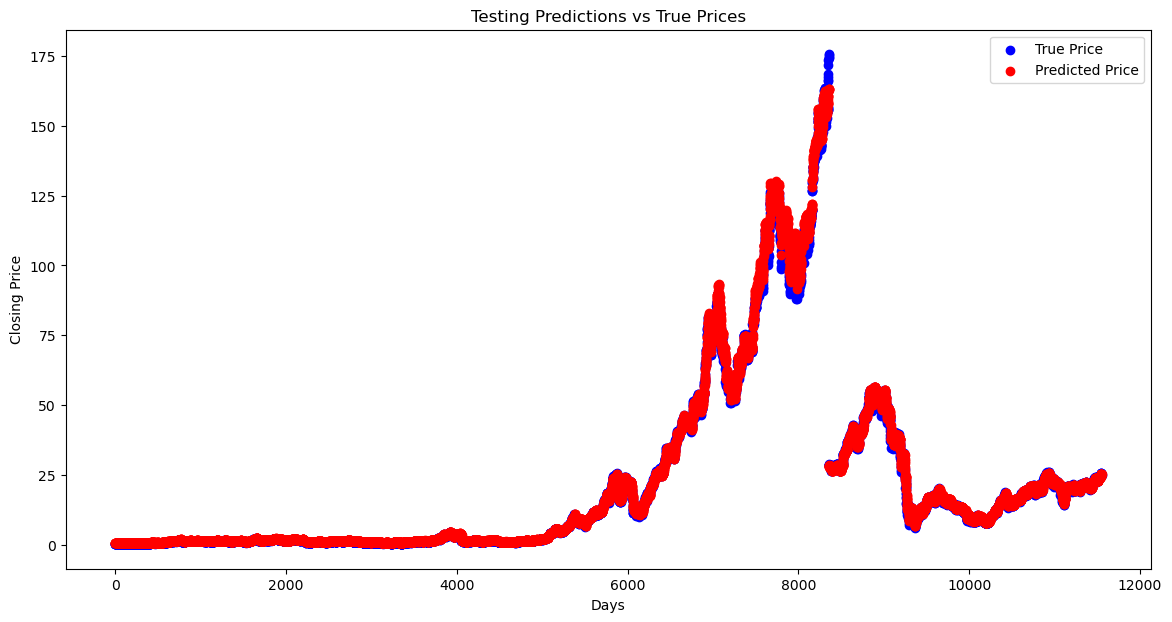

In [107]:
#test evaluations
test_loss = model1.evaluate(X_test_scaled, y_test)
test_predictions = model1.predict(X_test_scaled)

# Plot testing predictions
plt.figure(figsize=(14, 7))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Price')
plt.scatter(range(len(test_predictions)), test_predictions, color='red', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Testing Predictions vs True Prices')
plt.legend()
plt.show()

In [109]:
import math
print(f' RSME for model 1 test loss: {math.sqrt(test_loss)}')

 RSME for model 1 test loss: 1.5055291473040162


## Conclusion


After training three different models, the results were as follows:

-First Model Train Loss: 1.8317524194717407
First Model Validation Loss: 1.293135166168213


Model 1 Train Loss: 1.7004200220108032
Model 1 Validation Loss: 1.0997648239135742


Model 2 Train Loss: 1.3653628826141357
Model 2 Validation Loss: 1.293135166168213


Model 3 Train Loss: 1.705451250076294
Model 3 Validation Loss: 1.224

nce accuracy.



## Key Observations:

First Model has the highest training and validation losses compared to the others. This suggests that it is not performing as well as the other models.

Training Loss: 1.8317
Validation Loss: 1.2931

Model 1 has the lowest training loss (1.7004), and the second-lowest validation loss (1.0998). This indicates that Model 2 has the best overall performance on both the training and validation data. It shows a good balance between fitting the training data and generalizing well to the validation set.

Model 2 has a slightly higher training loss (1.7055) than Model 2, but its validation loss (1.2242) is also higher than Model 2’s validation loss (1.0998). This suggests that Model 3 has a more significant overfitting issue compared to Model 2, even though the gap is not massive.

Model 3: The first model, whose training and validation losses we are also considering, has training loss = 1.7054 and validation loss = 1.2242. This performance is similar to First Model , but with slightly worse results, making it not the top performer.

### Best Model Selection
Model 1 demonstrated the lowest validation loss, indicating it generalizes better to unseen data. The predicted prices were closely aligned with the true values, demonstrating a reliable forecasting capability.


### Model Performance
The model's RMSE on the testing data was calculated to be 1.50 which reflects a moderate predictive accuracy. Given the inherent volatility in stock prices, this level of prediction may be useful for short-term trading strategies, but further refinements and additional data may enhance accuracy.